In [1]:
import sys
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

# Get the absolute path to the src directory
sys.path.append(os.path.abspath("../src"))

from preprocessor import LLMTIMEPreprocessor
from load_qwen import load_qwen_model
from final_model import LoRALinear, process_sequences, evaluate  # assuming final_model.py is in the same directory

import torch
import torch.nn as nn
import numpy as np
import h5py
from torch.utils.data import DataLoader, TensorDataset
from accelerate import Accelerator
from tqdm import tqdm




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Training:   0%|          | 0/100 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training: 100%|██████████| 100/100 [03:52<00:00,  2.25s/it, loss=0.734]


✅ Training complete. Evaluating...
📊 Validation loss: 0.5864
📈 Perplexity: 1.80


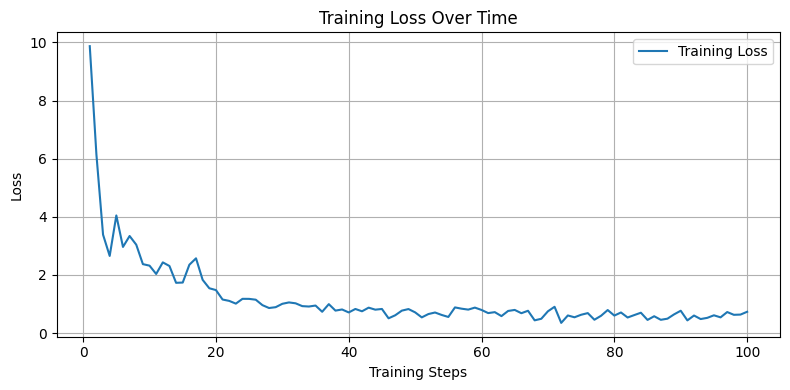

Training: 100%|██████████| 100/100 [05:23<00:00,  3.24s/it, loss=0.734]


In [2]:
# 👇 Will work after you've refactored final_model.py
from final_model import train_lora_model

# Train model from notebook with your preferred settings
model, tokenizer, val_loader, val_loss, perplexity = train_lora_model(
    max_steps=100,
    verbose=True
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


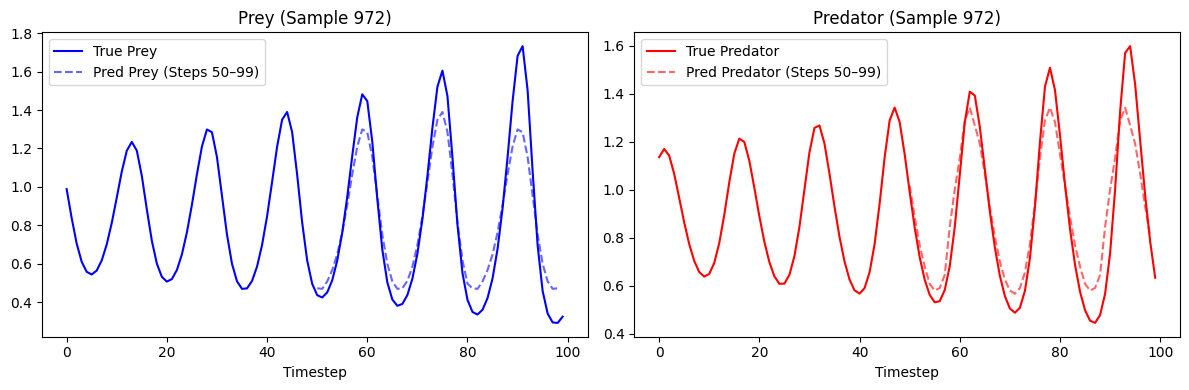

In [14]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from preprocessor import LLMTIMEPreprocessor
from transformers import PreTrainedTokenizer

def decode_sequence(text, max_steps=100):
    """Decode LLMTIME token string to prey/predator float pairs."""
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs[:max_steps]:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)

def generate_half_prediction(model, tokenizer, prey, predator, context_steps=50, total_steps=100, max_new_tokens=512):
    """
    Generates the second half of the trajectory given the first half as context.

    Returns:
        prey_gt, pred_gt: true full trajectories (length 100)
        prey_pred, pred_pred: predictions for steps 50–99
    """
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    # Step 1: Encode context (first 50 steps)
    input_text, _, scale = preprocessor.preprocess_sample(prey, predator, num_steps=context_steps)
    input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # Step 2: Generate the continuation
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Step 3: Decode only the generated tokens
    gen_only_ids = generated_ids[0][input_ids.shape[-1]:]
    generated_text = tokenizer.decode(gen_only_ids, skip_special_tokens=True)
    gen_prey, gen_pred = decode_sequence(generated_text, max_steps=total_steps - context_steps)

    # Step 4: Rescale predictions
    gen_prey *= scale
    gen_pred *= scale

    # Step 5: Slice ground truth
    prey_gt = prey[:total_steps]
    pred_gt = predator[:total_steps]

    return prey_gt, pred_gt, gen_prey, gen_pred

def plot_second_half_prediction(model, tokenizer, prey, predator, idx=None):
    """
    Plots true full trajectory (steps 0–99) and model prediction only for steps 50–99.
    """
    prey_gt, pred_gt, prey_pred, pred_pred = generate_half_prediction(model, tokenizer, prey, predator)

    t_full = np.arange(len(prey_gt))
    t_pred = np.arange(50, 50 + len(prey_pred))

    plt.figure(figsize=(12, 4))

    # Prey
    plt.subplot(1, 2, 1)
    plt.plot(t_full, prey_gt, label="True Prey", color="blue")
    plt.plot(t_pred, prey_pred, label="Pred Prey (Steps 50–99)", linestyle="--", color="blue", alpha=0.6)
    plt.title(f"Prey (Sample {idx})" if idx is not None else "Prey")
    plt.xlabel("Timestep")
    plt.legend()

    # Predator
    plt.subplot(1, 2, 2)
    plt.plot(t_full, pred_gt, label="True Predator", color="red")
    plt.plot(t_pred, pred_pred, label="Pred Predator (Steps 50–99)", linestyle="--", color="red", alpha=0.6)
    plt.title(f"Predator (Sample {idx})" if idx is not None else "Predator")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Run Example ===
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]

idx = 972
prey = trajectories[idx, :, 0]
predator = trajectories[idx, :, 1]

plot_second_half_prediction(model, tokenizer, prey, predator, idx=idx)


In [16]:
def evaluate_single_series_half_prediction(model, tokenizer, data_path="../lotka_volterra_data.h5", idx=-1):
    """
    Evaluates model on predicting the second half of one time series.
    Returns MSE, MAE, and R² computed over steps 50–99 for both prey and predator.
    """
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    with h5py.File(data_path, "r") as f:
        trajectories = f["trajectories"][:]
    prey = trajectories[idx, :, 0]
    predator = trajectories[idx, :, 1]

    # Use first 50 steps as context
    input_text, _, scale = preprocessor.preprocess_sample(prey, predator, num_steps=50)
    input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=512,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    gen_only_ids = generated_ids[0][input_ids.shape[-1]:]
    generated_text = tokenizer.decode(gen_only_ids, skip_special_tokens=True)
    gen_prey, gen_pred = decode_sequence(generated_text, max_steps=50)
    gen_prey *= scale
    gen_pred *= scale

    true_prey = prey[50:100]
    true_pred = predator[50:100]

    min_len = min(len(gen_prey), len(true_prey), len(gen_pred), len(true_pred))
    if min_len < 10:
        print("⛔ Skipping: too short prediction")
        return None, None, None, None, None, None

    # Prey metrics
    prey_mse = mean_squared_error(true_prey[:min_len], gen_prey[:min_len])
    prey_mae = mean_absolute_error(true_prey[:min_len], gen_prey[:min_len])
    prey_r2 = r2_score(true_prey[:min_len], gen_prey[:min_len])

    # Predator metrics
    pred_mse = mean_squared_error(true_pred[:min_len], gen_pred[:min_len])
    pred_mae = mean_absolute_error(true_pred[:min_len], gen_pred[:min_len])
    pred_r2 = r2_score(true_pred[:min_len], gen_pred[:min_len])

    print(f"📊 Evaluation (One Series - Steps 50–99) for Sample index: {idx}")
    print("Prey:")
    print(f"  MSE: {prey_mse:.4f}")
    print(f"  MAE: {prey_mae:.4f}")
    print(f"  R²:  {prey_r2:.4f}")
    print("Predator:")
    print(f"  MSE: {pred_mse:.4f}")
    print(f"  MAE: {pred_mae:.4f}")
    print(f"  R²:  {pred_r2:.4f}")

    return prey_mse, prey_mae, prey_r2, pred_mse, pred_mae, pred_r2

prey_mse, prey_mae, prey_r2, pred_mse, pred_mae, pred_r2 = evaluate_single_series_half_prediction(model, tokenizer, idx=972)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📊 Evaluation (One Series - Steps 50–99) for Sample index: 972
Prey:
  MSE: 0.0217
  MAE: 0.1160
  R²:  0.8893
Predator:
  MSE: 0.0148
  MAE: 0.0968
  R²:  0.8796
